# # Neural Network Basics and Word2Vec
AU 17 CSE 5539-0010 "Social Media and Text Analysis" Homework #3  
Wei Xu, The Ohio State University   

In this assignment, we will walk you through the process of implementing: 

- A softmax function and a sigmoid function
- A simple neural network with back propagation
- Word2vec models (Skip-gram, CBOW) with negative sampling

and training your own word vectors with stochastic gradient descent (SGD). The purpose of this assignment is to familiarize you with basic knowledge about neural networks and help you gain proficiency in writing efficient, vectorized code.

You may find this **[documentation](http://cs224d.stanford.edu/assignment1/assignment1_soln)** very helpful, as it will walk you through all the math needed for this assignment.

<div class="alert alert-danger">
IMPORTANG: In this assignment, except Numpy and Matplotlib, no other external Python packages are allowed. Scipy is used in gradient checking, though, it is not allowed elsewhere. Please don't add or remove any code cells, as it might break our automatic grading system and affect your grade.
</div>

**Honor Code:** I hereby agree to abide the Ohio State University's Code of Student Conduct, promise that the submitted assignment is my own work, and understand that my code is subject to plagiarism test.

**Signature**: *(Pragya Arora)*

In [19]:
# Run some setup code for this notebook. Don't modify anything in this cell.

import random
import numpy as np
from data_utils import *
import matplotlib.pyplot as plt
from scipy.special import expit

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Neural Network Basics [Bonus 5 Points]

In this part, you're going to implement

* A softmax function
* A sigmoid activation function and its gradient
* A forward propagation for a simple neural network with cross-entropy cost
* A backward propagation algorithm to compute gradients for the parameters
* Gradient checking

### 1.1 Softmax

The softmax function is defined as $softmax(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j}{e^{x_j}}}$. 


And conveniently, softmax is invarint to constant offsets in the input, that is, for any input vector $\mathbf{x}$ and any constant $c$, $softmax(\mathbf{x})=softmax(\mathbf{x}+c)$, where $\mathbf{x}+c$ means adding the constant $c$ to every dimension of $\mathbf{x}$. 

**Show your efficient implementation of the softmax function in Python below. The computional efficienicy is crucial because this function will be used frequently in later code. ** 

You will find numpy functions np.exp, np.sum, np.reshape, np.max, and [numpy broadcasting](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) useful. Numpy is a Python package for scientific programming. You can find a nice **Numpy tutoral** [here](http://cs231n.github.io/python-numpy-tutorial/).


Given an input matrix of *N* rows and *d* columns, compute the softmax prediction for each row. That is, when the input is

    [[1,2],
    [3,4]]
    
the output of your functions should be

    [[0.2689, 0.7311],
    [0.2689, 0.7311]]

In [20]:
def softmax(x):
    """ Softmax function """
    ###################################################################
    # Compute the softmax function for the input here.                #
    # It is crucial that this function is optimized for speed because #
    # it will be used frequently in later code.                       #
    # You might find numpy functions np.exp, np.sum, np.reshape,      #
    # np.max, and numpy broadcasting useful for this task. (numpy     #
    # broadcasting documentation:                                     #
    # http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)  #
    # You should also make sure that your code works for one          #
    # dimensional inputs (treat the vector as a row), you might find  #
    # it helpful for your later problems.                             #
    ###################################################################
    
    ### YOUR CODE HERE
    if x.ndim <= 1:
        x = x - np.max(x)
        ex = np.exp(x)
        return ex/np.sum(ex)
    else:
        max = np.max(x, axis=1)
        max = max[:, np.newaxis]
        x = x - max
        ex = np.exp(x)
        sum = np.sum(ex, axis=1)
        sum = sum[:, np.newaxis]
        return ex / sum
    
    ### END YOUR CODE
    
    return x

In [21]:
# Verify your softmax implementation

print ("=== For autograder ===")
print (softmax(np.array([[1001,1002],[3,4]])))
print (softmax(np.array([[-1001,-1002]])))

=== For autograder ===
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]
[[ 0.73105858  0.26894142]]


### 1.2 Sigmoid 

The sigmoid function is defined as $sigmoid(\mathbf{x})_i = \frac{1}{1+{e^{-x_i}}}$


In [22]:
def sigmoid(x):
    """ Sigmoid function """
    ###################################################################
    # Compute the sigmoid function for the input here.                #
    ###################################################################
    
    ### YOUR CODE HERE
    
    x = 1.0/(1+np.exp(-x))
    
    ### END YOUR CODE
    
    return x

def sigmoid_grad(f):
    """ Sigmoid gradient function """
    ###################################################################
    # Compute the gradient for the sigmoid function here. Note that   #
    # for this implementation, the input f should be the sigmoid      #
    # function value of your original input x.                        #
    ###################################################################
    
    ### YOUR CODE HERE
   
    y = f*(1-f)

    ### END YOUR CODE
    return y

In [23]:
# Check your sigmoid implementation
x = np.array([[1, 2], [-1, -2]])
f = sigmoid(x)
g = sigmoid_grad(f)
print ("=== For autograder ===")
print (f)
print (g)

=== For autograder ===
[[ 0.73105858  0.88079708]
 [ 0.26894142  0.11920292]]
[[ 0.19661193  0.10499359]
 [ 0.19661193  0.10499359]]


### 1.3 Gradient Checking

[Gradient checking](http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/) is an important technique for debugging the gradient computation. Logistic regression is a relatively simple algorithm where it is straightforward to derive and implement its cost function and gradient computation. For more complex models, the gradient computaitn can be notoriously difficulty to debug and get right. Sometimes a subtly buggy implementation will manage to learn something that can look surprisingly reasonable, while performing less well than a correct implementation. Thus, even with a buggy implementation, it may not at all be apparent that anything is amiss. 

In [24]:
# First implement a gradient checker by filling in the following functions
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        ### try modifying x[ix] with h defined above to compute numerical gradients
        ### make sure you call random.setstate(rndstate) before calling f(x) each time, this will make it 
        ### possible to test cost functions with built in randomness later
        ### YOUR CODE HERE:

        random.setstate(rndstate)
        x_ix = x[ix]
        x[ix] = x_ix +h
        grad_plus = f(x)[0]
        
        random.setstate(rndstate)
        x[ix] = x_ix - h
        grad_minus = f(x)[0]
        
        numgrad = (grad_plus-grad_minus)/(2*h)
        x[ix] = x_ix
        ### END YOUR CODE

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print ("Gradient check failed.")
            print ("First gradient error found at index %s" % str(ix))
            print ("Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad))
            return
    
        it.iternext() # Step to next dimension

    print ("Gradient check passed!")

In [25]:
# Sanity check for the gradient checker
quad = lambda x: (np.sum(x ** 2), x * 2)

print ("=== For autograder ===")
gradcheck_naive(quad, np.array(123.456))      # scalar test
gradcheck_naive(quad, np.random.randn(3,))    # 1-D test
gradcheck_naive(quad, np.random.randn(4,5))   # 2-D test

=== For autograder ===
Gradient check passed!
Gradient check passed!
Gradient check passed!


### 1.4 Back Propagation

Now, use the functions you just implemented, fill in the following functions to implement a neural network with one sigmoid hidden layer. You may skip this 1.4 section, and implement the word2vec below directly. 

In [26]:
# Set up fake data and parameters for testing the neural network

N = 20
dimensions = [10, 5, 10]
data = np.random.randn(N, dimensions[0])   # each row will be a datum
labels = np.zeros((N, dimensions[2]))

for i in range(N):
    labels[i,random.randint(0,dimensions[2]-1)] = 1
params = np.random.randn((dimensions[0] + 1) * dimensions[1] + (dimensions[1] + 1) * dimensions[2], )

In [28]:
def forward_backward_prop(data, labels, params):
    "forward_backward_prop"" Forward and backward propagation for a two-layer sigmoidal network """
    ###################################################################
    # Compute the forward propagation and for the cross entropy cost, #
    # and backward propagation for the gradients for all parameters.  #
    ###################################################################
    
    ### Unpack network parameters (do not modify)
    t = 0
    W1 = np.reshape(params[t:t+dimensions[0]*dimensions[1]], (dimensions[0], dimensions[1])) # (10,5)
    t += dimensions[0]*dimensions[1]
    b1 = np.reshape(params[t:t+dimensions[1]], (1, dimensions[1])) # (1, 5)
    t += dimensions[1]
    W2 = np.reshape(params[t:t+dimensions[1]*dimensions[2]], (dimensions[1], dimensions[2]))  # (5, 10)
    t += dimensions[1]*dimensions[2]
    b2 = np.reshape(params[t:t+dimensions[2]], (1, dimensions[2])) # (1, 10)
    
    ### YOUR CODE HERE: forward propagation (calculate the cost as cross entropy error)
    
    h = sigmoid(data.dot(W1)+b1)
    o = softmax(h.dot(W2)+b2)
    cost =  - np.sum(np.multiply(labels, np.log(o)))
    
    ### END YOUR CODE
    
    ### YOUR CODE HERE: backward propagation
    delta1 = o-labels
    gradW2 = h.T.dot(delta1)
    gradb2 = np.sum(delta1,axis=0)
    
    delta2 = np.multiply(delta1.dot(W2.T),sigmoid_grad(h))
    gradW1 = data.T.dot(delta2)
    gradb1 = np.sum(delta2,axis=0)
    
    ### END YOUR CODE
    
    ### Stack gradients (do not modify)
    grad = np.concatenate((gradW1.flatten(), gradb1.flatten(), gradW2.flatten(), gradb2.flatten()))
    
    return cost, grad

In [29]:
# Perform gradcheck on your neural network
print ("=== For autograder ===")
gradcheck_naive(lambda params: forward_backward_prop(data, labels, params), params)

=== For autograder ===
Gradient check passed!


## 2. Word2vec [Bonus 15 Points]

In this part you will implement the `word2vec` models and train your own word vectors with stochastic gradient descent (SGD). You may find the following readings helpful:

- [Lecture Note on Skip-gram, CBOW and Negative Sampling](http://cs224d.stanford.edu/lecture_notes/notes1.pdf) by Francois Chaubard, Rohit Mundra, Richard Socher
- [Semantics with Dense Vectors](https://web.stanford.edu/~jurafsky/slp3/16.pdf) (Speech and Language Processing, Chapter 16) by Dan Jurafsky and James H. Martin



In [30]:
# Implement a function that normalizes each row of a matrix to have unit length

def normalizeRows(x):
    """ Row normalization function """
    # Implement a function that normalizes each row of a matrix to have unit length
    
    ### YOUR CODE HERE
    
    s = np.sqrt(np.sum(x**2,axis=1,keepdims=True))
    x=x/s
    
    
    ### END YOUR CODE
    
    return x

# Test this function
print ("=== For autograder ===")
print (normalizeRows(np.array([[3.0,4.0],[1, 2]])))  # the result should be [[0.6, 0.8], [0.4472, 0.8944]]

=== For autograder ===
[[ 0.6         0.8       ]
 [ 0.4472136   0.89442719]]


In [31]:
# Implement your skip-gram and CBOW models here

def softmaxCostAndGradient(predicted, target, outputVectors, dataset):
    """ Softmax cost function for word2vec models """
    
    # Implement the cost and gradients for one predicted word vector  
    # and one target word vector as a building block for word2vec     
    # models, assuming the softmax prediction function and cross      
    # entropy loss.                                                   
    
    # Inputs:                                                         
    # - predicted: numpy ndarray, predicted word vector (\hat{v} in 
    #   the written component or \hat{r} in an earlier version)
    # - target: integer, the index of the target word               
    # - outputVectors: "output" vectors (as rows) for all tokens     
    # - dataset: needed for negative sampling, unused here.         
    
    # Outputs:                                                        
    # - cost: cross entropy cost for the softmax word prediction    
    # - gradPred: the gradient with respect to the predicted word   
    #        vector                                                
    # - grad: the gradient with respect to all the other word        
    #        vectors                                                                                             
    
    ### YOUR CODE HERE
    
    v_c = predicted
    U = outputVectors
    z = v_c.dot(U.T)
    y_hat = softmax(z)
    cost = -np.log(y_hat[target])
    
    y_hat_minus_y = y_hat.copy()
    y_hat_minus_y[target] -= 1.
    
    gradPred = U.T.dot(y_hat_minus_y)
    
    grad = np.outer(y_hat_minus_y, v_c)    
    
    ### END YOUR CODE
    
    return cost, gradPred, grad

def negSamplingCostAndGradient(predicted, target, outputVectors, dataset, 
    K=10):
    """ Negative sampling cost function for word2vec models """

    # Implement the cost and gradients for one predicted word vector  
    # and one target word vector as a building block for word2vec     
    # models, using the negative sampling technique. K is the sample  
    # size. You might want to use dataset.sampleTokenIdx() to sample  
    # a random word index. 
    # 
    # Note: See test_word2vec below for dataset's initialization.
    #                                       
    # Input/Output Specifications: same as softmaxCostAndGradient     

    
    ### YOUR CODE HERE
    
    u_o = outputVectors[target]
    v_c = predicted
    gradPred = np.zeros(predicted.shape)
    grad = np.zeros(outputVectors.shape)
    cost = 0.0
    sigmoidVal = sigmoid(u_o.dot(v_c))
    cost -= np.log(sigmoidVal)
    gradPred += u_o * (sigmoidVal-1.)
    grad[target]+= v_c * (sigmoidVal-1.)
    
    for k in range(K):
        curr_idx = dataset.sampleTokenIdx()
        u_k = outputVectors[curr_idx]
        sigmoidVal = sigmoid(u_k.dot(v_c))
        ## using sigmoid(-x) = 1-sigmoid(x)
        cost -= np.log(1. - sigmoidVal)
        gradPred += sigmoidVal * u_k
        grad[curr_idx] += sigmoidVal * v_c
        
    ### END YOUR CODE
    
    return cost, gradPred, grad


def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """

    # Implement the skip-gram model in this function.

    # Inputs:                                                         
    # - currrentWord: a string of the current center word           
    # - C: integer, context size                                    
    # - contextWords: list of no more than 2*C strings, the context words                                               
    # - tokens: a dictionary that maps words to their indices in    
    #      the word vector list                                
    # - inputVectors: "input" word vectors (as rows) for all tokens           
    # - outputVectors: "output" word vectors (as rows) for all tokens         
    # - word2vecCostAndGradient: the cost and gradient function for 
    #      a prediction vector given the target word vectors,  
    #      could be one of the two cost functions you          
    #      implemented above

    # Outputs:                                                        
    # - cost: the cost function value for the skip-gram model       
    # - grad: the gradient with respect to the word vectors         

    ### YOUR CODE HERE
    cost = 0.0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)
    
    current_word_index = tokens[currentWord]
    v_c = inputVectors[current_word_index]
    
    for ctx in contextWords:
        target = tokens[ctx]
        c, g_in, g_out = word2vecCostAndGradient(v_c, target, outputVectors, dataset)
        cost += c
        gradIn[current_word_index] += g_in
        gradOut += g_out
    
    
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

def cbow(currentWord, C, contextWords, tokens, inputVectors, outputVectors, 
    dataset, word2vecCostAndGradient = softmaxCostAndGradient):
    """ CBOW model in word2vec """

    # Implement the continuous bag-of-words model in this function.            
    # Input/Output specifications: same as the skip-gram model        
    
    cost = 0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)
    
    ### YOUR CODE HERE
    v_hat = np.zeros((inputVectors.shape[1], ))
    for j in contextWords:
        curr_word_idx = tokens[j]
        v_hat += inputVectors[curr_word_idx]
        
    v_hat = v_hat
    
    cost, gradPred, grad = word2vecCostAndGradient(v_hat, tokens[currentWord], outputVectors, dataset)
    gradOut = grad
    
    for j in contextWords:
        curr_word_idx = tokens[j]
        gradIn[curr_word_idx] += gradPred

    ### END YOUR CODE
    
    return cost, gradIn, gradOut



In [32]:
# Gradient check!

def word2vec_sgd_wrapper(word2vecModel, tokens, wordVectors, dataset, C, word2vecCostAndGradient = softmaxCostAndGradient):
    batchsize = 50
    cost = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    inputVectors = wordVectors[:int(N/2),:]
    outputVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        C1 = random.randint(1,C)
        centerword, context = dataset.getRandomContext(C1)
        
        if word2vecModel == skipgram:
            denom = 1
        else:
            denom = 1
        
        c, gin, gout = word2vecModel(centerword, C1, context, tokens, inputVectors, outputVectors, dataset, word2vecCostAndGradient)
        cost += c / batchsize / denom
        grad[:int(N/2), :] += gin / batchsize / denom
        grad[int(N/2):, :] += gout / batchsize / denom
        
    return cost, grad

# Interface to the dataset for negative sampling
dataset = type('dummy', (), {})()
def dummySampleTokenIdx():
    return random.randint(0, 4)

def getRandomContext(C):
    tokens = ["a", "b", "c", "d", "e"]
    return tokens[random.randint(0,4)], [tokens[random.randint(0,4)] for i in range(2*C)]
dataset.sampleTokenIdx = dummySampleTokenIdx
dataset.getRandomContext = getRandomContext

random.seed(31415)
np.random.seed(9265)
dummy_vectors = normalizeRows(np.random.randn(10,3))
dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])
print ("==== Gradient check for skip-gram ====")
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)
print ("\n==== Gradient check for CBOW      ====")
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)

print ("\n=== Results ===")
print (skipgram("c", 3, ["a", "b", "e", "d", "b", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset))
print (skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset, negSamplingCostAndGradient))
print (cbow("a", 2, ["a", "b", "c", "a"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset))
print (cbow("a", 2, ["a", "b", "a", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset, negSamplingCostAndGradient))


==== Gradient check for skip-gram ====
Gradient check passed!
Gradient check passed!

==== Gradient check for CBOW      ====
Gradient check passed!
Gradient check passed!

=== Results ===
(11.166109001533981, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.26947339, -1.36873189,  2.45158957],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.41045956,  0.18834851,  1.43272264],
       [ 0.38202831, -0.17530219, -1.33348241],
       [ 0.07009355, -0.03216399, -0.24466386],
       [ 0.09472154, -0.04346509, -0.33062865],
       [-0.13638384,  0.06258276,  0.47605228]]))
(13.855545353810484, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-3.16769624, -2.64259997, -1.31406475],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.11265089,  0.05169237,  0.3932116

In [33]:
# Now, implement SGD

# Save parameters every a few SGD iterations as fail-safe
SAVE_PARAMS_EVERY = 1000

import glob
import os.path as op
import pickle

def load_saved_params():
    """ A helper function that loads previously saved parameters and resets iteration start """
    st = 0
    for f in glob.glob("./saved_params/saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter
            
    if st > 0:
        with open("./saved_params/saved_params_%d.npy" % st, "rb") as f:
            params = pickle.load(f)
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None
    
def save_params(iter, params):
    with open("./saved_params/saved_params_%d.npy" % iter, "wb") as f:
        pickle.dump(params, f)
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing = None, useSaved = False, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    # Implement the stochastic gradient descent method in this        
    # function.                                                       
    
    # Inputs:                                                         
    # - f: the function to optimize, it should take a single        
    #     argument and yield two outputs, a cost and the gradient  
    #     with respect to the arguments                            
    # - x0: the initial point to start SGD from                     
    # - step: the step size for SGD                                 
    # - iterations: total iterations to run SGD for                 
    # - postprocessing: postprocessing function for the parameters  
    #     if necessary. In the case of word2vec we will need to    
    #     normalize the word vectors to have unit length.          
    # - PRINT_EVERY: specifies every how many iterations to output  

    # Output:                                                         
    # - x: the parameter value after SGD finishes  
    
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000
    
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx;
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)
            
        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x = x0
    
    if not postprocessing:
        postprocessing = lambda x: x
    
    expcost = None
    
    for iter in range(start_iter + 1, iterations + 1):

        cost = None
        ### YOUR CODE HERE
        x = postprocessing(x)
        cost, grad = f(x)
        x -= step * grad
        ### END YOUR CODE
 
       ### You might want to print the progress every few iterations.
        if iter % PRINT_EVERY == 0:
            if not expcost:
                expcost = cost
            else:
                expcost = .95 * expcost + .05 * cost
            print ("iter %d: %f" % (iter, expcost))
        
        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            print (x)
            save_params(iter, x)
            
        if iter % ANNEAL_EVERY == 0:
            step *= 0.5
    
    return x

quad = lambda x: (np.sum(x ** 2), x * 2)

print ("Running sanity checks...")
t1 = sgd(quad, 0.5, 0.01, 1000, PRINT_EVERY=100)
print ("test 1 result:", t1)
assert abs(t1) <= 1e-6

t2 = sgd(quad, 0.0, 0.01, 1000, PRINT_EVERY=100)
print ("test 2 result:", t2)
assert abs(t2) <= 1e-6
    
t3 = sgd(quad, -1.5, 0.01, 1000, PRINT_EVERY=100)
print ("test 3 result:", t3)
assert abs(t3) <= 1e-6


Running sanity checks...
iter 100: 0.004578
iter 200: 0.004353
iter 300: 0.004136
iter 400: 0.003929
iter 500: 0.003733
iter 600: 0.003546
iter 700: 0.003369
iter 800: 0.003200
iter 900: 0.003040
iter 1000: 0.002888
test 1 result: 8.414836786079764e-10
iter 100: 0.000000
iter 200: 0.000000
iter 300: 0.000000
iter 400: 0.000000
iter 500: 0.000000
iter 600: 0.000000
iter 700: 0.000000
iter 800: 0.000000
iter 900: 0.000000
iter 1000: 0.000000
test 2 result: 0.0
iter 100: 0.041205
iter 200: 0.039181
iter 300: 0.037222
iter 400: 0.035361
iter 500: 0.033593
iter 600: 0.031913
iter 700: 0.030318
iter 800: 0.028802
iter 900: 0.027362
iter 1000: 0.025994
test 3 result: -2.524451035823933e-09


**Show time! Now we are going to load some real data and train word vectors with everything you just implemented!**

We are going to use the Stanford Sentiment Treebank (SST) dataset to train word vectors, and visualize them.

In [34]:
# Load some data and initialize word vectors

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5


In [35]:
# Train word vectors (this could take a while!)

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)
wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - .5) / dimVectors, np.zeros((nWords, dimVectors))), axis=0)
wordVectors0 = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, negSamplingCostAndGradient), 
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)

# sanity check: cost at convergence should be around or below 10

# sum the input and output word vectors
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])



print ("=== For autograder ===")
print ()
checkWords = ["the", "a", "an", "movie", "ordinary", "but", "and"]
checkIdx = [tokens[word] for word in checkWords]
checkVecs = wordVectors[checkIdx, :]
print (checkVecs)

iter 10: 19.671511
iter 20: 19.663885
iter 30: 19.618522
iter 40: 19.735538
iter 50: 19.793328
iter 60: 19.954973
iter 70: 20.032293
iter 80: 20.006632
iter 90: 20.012751
iter 100: 19.995686
iter 110: 20.109093
iter 120: 20.262572
iter 130: 20.377890
iter 140: 20.449314
iter 150: 20.433291
iter 160: 20.341826
iter 170: 20.552283
iter 180: 20.645484
iter 190: 20.734027
iter 200: 20.802883
iter 210: 20.868304
iter 220: 20.755092
iter 230: 20.868651
iter 240: 20.877432
iter 250: 20.862879
iter 260: 21.039670
iter 270: 21.177116
iter 280: 21.071350
iter 290: 21.024238
iter 300: 21.086222
iter 310: 21.045983
iter 320: 21.099227
iter 330: 21.149829
iter 340: 21.091133
iter 350: 21.187873
iter 360: 21.211172
iter 370: 21.218050
iter 380: 21.163589
iter 390: 21.142335
iter 400: 21.289905
iter 410: 21.353815
iter 420: 21.460299
iter 430: 21.500457
iter 440: 21.477615
iter 450: 21.364472
iter 460: 21.272191
iter 470: 21.207400
iter 480: 21.222083
iter 490: 21.441922
iter 500: 21.338136
iter 510:

(-0.13540929075828714, 0.23031135146414772)

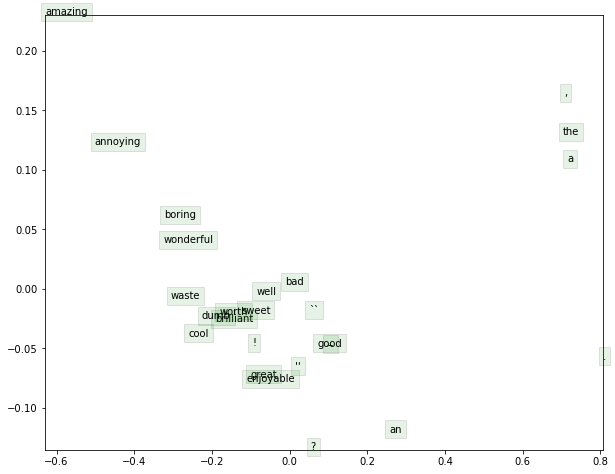

In [36]:

# Visualize the word vectors you trained
_, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", "good", "great", "cool", "brilliant", 
                  "wonderful", "well", "amazing","worth", "sweet", "enjoyable", "boring", "bad", "waste", 
                  "dumb", "annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))
